In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math 

In [2]:
def load(fname):
    with open(fname) as fin:
        return np.array([list(map(float, s[:-1].split(','))) for s in fin.readlines()])

In [3]:
def show_data(data):
    for [x,y,label] in data:
        plt.plot(x,y, 'bo' if label < 0.5 else 'ro')
    plt.show()

In [4]:
def getMinkowskiDistance(p):
    return lambda a, b : sum(abs(a - b) ** p) ** (1 / p)

In [5]:
def f(x, y):
    return y if x < 1 else 0
def uniform(x):
    return f(x, 0.5)
def triangle(x):
    return f(x, 1 - x)
def epanechnikov(x):
    return f(x, 3 / 4 * (1 - x ** 2))
def quartic(x):
    return f(x, 15 / 16 * (1 - x ** 2) ** 2)
def triweight(x):
    return f(x, 35 / 32 * (1 - x ** 2) ** 3)
def gaussian(x):
    return math.e ** (-1 / 2 * x ** 2) / (2 * math.pi) ** 0.5
def cosine(x):
    return f(x, math.pi / 4 * math.cos(x / 2 * math.pi))

In [6]:
class PRWindow:        
    def __init__(self, data, k = 5, distance_f = getMinkowskiDistance(2), kernel = uniform):
        self.data = data
        self.k = k
        self.ro = distance_f
        self.kernel = kernel
    
    def getC(self, x):
        d = sorted(self.data, key = lambda z: self.ro(x, z[:-1]))
        classes = {}
        for xi in d:
            classes.setdefault(xi[-1], 0)
            classes[xi[-1]] += self.kernel(self.ro(x, xi[:-1]) / self.ro(x, d[self.k][:-1]))
        return classes
    
    def fit(self, x):
        classes = self.getC(x)
        return max([(classes[cl], cl) for cl in classes])[1]
    
    def margin(self, x, y):
        classes = self.getC(x)
        return classes[y] - max([(classes[cl], cl) for cl in classes if cl != y])[0]

In [7]:
def L(model, x):
    return int(model.fit(x[:-1]) != x[-1])

def defQ(model, xs):
    return sum(map(lambda p: L(model, p), xs)) / len(xs)

def F1(model, xs):
    TP = FP = TN = FN = 0
    for t in xs:
        cl = model.fit(t[:-1])
        if cl == 1.0:
            if cl == t[-1]:
                TP += 1
            else:
                FN += 1
        else:
            if cl == t[-1]:
                TN += 1
            else:
                FP += 1
    try:
        P = TP + FN
        N = TN + FP
        recall = TP / P
        precision = TP / (TP + FP)
        return 1 - (2 * precision * recall) / (precision + recall)
    except ZeroDivisionError:
        return 1

def randomizedCV(model, t, k):
    err = 0
    olddata = model.data.copy()
    tdata = model.data
    for _ in range(k):
        np.random.shuffle(tdata)
        step = len(tdata) / t
        for i in range(t):
            l, r = int(step * i), int(step * (i + 1))
            model.data = np.append(tdata[ : l], tdata[r : ], axis = 0)
            err += Q(model, tdata[l : r]) / t / k
    model.data = olddata
    return err

In [8]:
def try_k(model, k, blocks, split_times):
    model.k = k
    return randomizedCV(model, blocks, split_times)

def getCVs(model, ks, blocks, split_times):
    return np.array(list(map(lambda k: try_k(model, k, blocks, split_times), ks)))

In [9]:
def x2plusy2(xs):
    return [x[0] ** 2 + x[1] ** 2 for x in xs]
def xy(xs):
    return [x[0] * x[1] for x in xs]
def addC(xs, f):
    return np.insert(xs, 2, f(xs), axis = 1)
def trans1(xs):
    return addC(xs, x2plusy2)
def trans2(xs):
    return addC(xs, xy)

In [10]:
def show_info(distancef, tr_space, error_f, kernel_f = uniform, CVks = [7]):
    global Q
    Q = error_f
    tr_train = tr_space(train)
    tr_test = tr_space(test)
    
    qCVKs = []
    ps = []
    ks = range(1, int(len(tr_train) ** 0.5) + 1, 2)
    cvs = np.zeros(len(ks))
    
    for CVk in CVks:
        knn = PRWindow(tr_train, distance_f = distancef, kernel=kernel_f)
        cvs += getCVs(knn, ks, CVk, 7)

    qs = [Q(PRWindow(tr_train, k = k, distance_f = distancef, kernel=kernel_f), tr_test) for k in ks]
    
    bestk = ks[cvs.argmin()]
    knn.k = bestk
    
    plt.plot(ks, cvs)
    plt.xlabel('k')
    plt.ylabel('CV')
    plt.show()
    plt.xlabel('k')
    plt.ylabel('Q' if error_f == defQ else 'F1')
    plt.plot(ks, qs)
    plt.show()    
    
    print('best k:', bestk)
    print('Q(testx, testy)', bestk, ':', defQ(knn, tr_test))
    print('F1(testx, testy)', bestk, ':', 1 - F1(knn, tr_test))
    
    for i in range(len(tr_train)):
        t = tr_train[i]
        knn.data = np.delete(tr_train, i, axis = 0)
        if knn.margin(t[:-1], t[-1]) <= -1:
            plt.plot(t[0], t[1], 'bx' if t[-1] < 0.5 else 'rx')
        else:
            plt.plot(t[0], t[1], 'bo' if t[-1] < 0.5 else 'ro')
    plt.show()
    
    a, b = -0.75, 1.00
    c, d = -0.75, 1.00
    
    knn.data = tr_train
    todraw = []
    NN = 25
    for i in range(NN):
        for j in range(NN):
            todraw.append([a + (b - a) * i / NN, c + (d - c) * j / NN])
    todraw = np.array(todraw)
    tr_draw = tr_space(todraw)
    for t in tr_draw:
        plt.plot(t[0], t[1], 'bo' if knn.fit(t) < 0.5 else 'ro')
    plt.show()

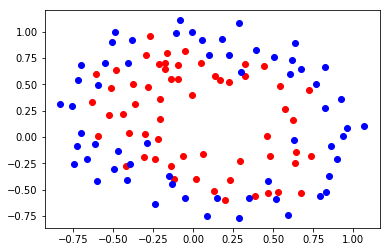

In [11]:
data = load('chips.txt')
show_data(data)

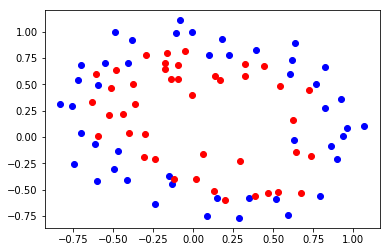

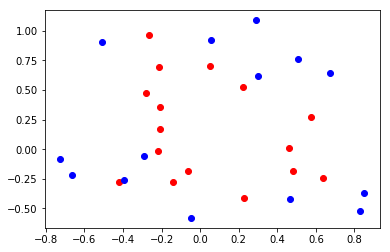

In [12]:
testsize = 30
seed = np.random.randint(1, 100)
train, test = train_test_split(data, train_size = len(data) - testsize, test_size = testsize, random_state = seed)
show_data(train)
show_data(test)

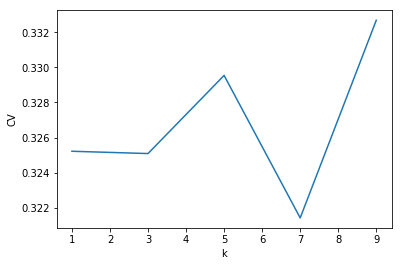

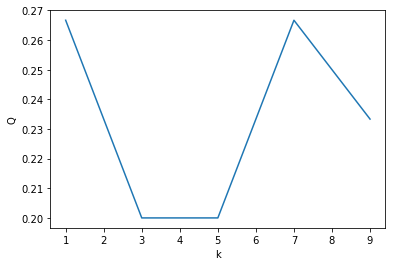

best k: 7
Q(testx, testy) 7 : 0.26666666666666666
F1(testx, testy) 7 : 0.7647058823529411


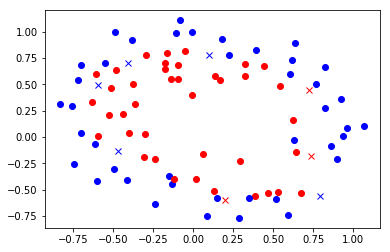

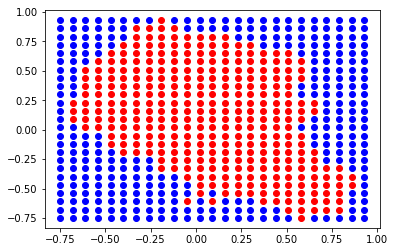

In [13]:
#без пространственных изменений, L1
show_info(getMinkowskiDistance(1), lambda x: x, defQ)

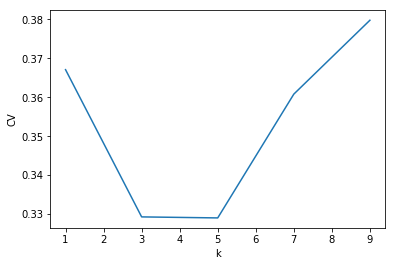

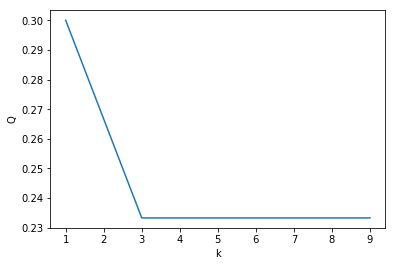

best k: 5
Q(testx, testy) 5 : 0.23333333333333334
F1(testx, testy) 5 : 0.787878787878788


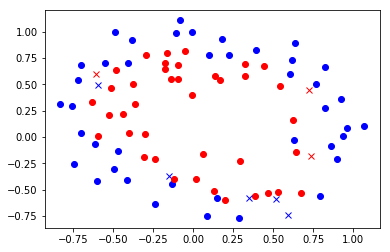

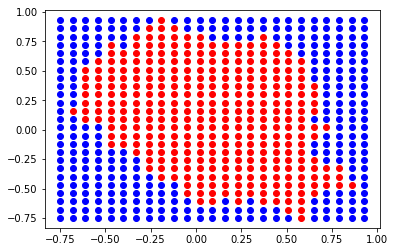

In [14]:
#без пространственных изменений, L2
show_info(getMinkowskiDistance(2), lambda x: x, defQ)

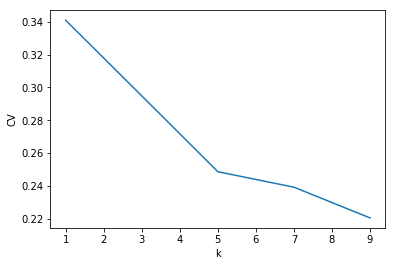

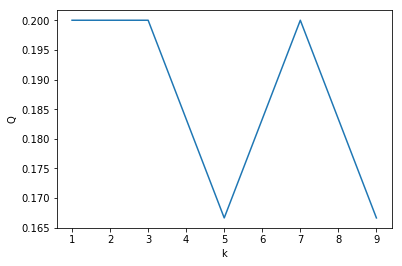

best k: 9
Q(testx, testy) 9 : 0.16666666666666666
F1(testx, testy) 9 : 0.8484848484848485


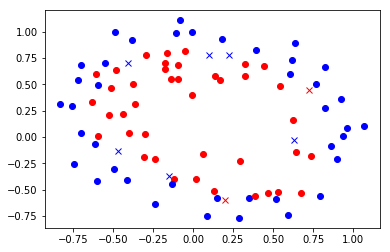

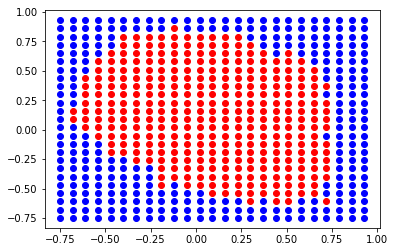

In [15]:
#добавляем третюю компоненту(x ** 2 + y ** 2), L1
show_info(getMinkowskiDistance(1), trans1, defQ)

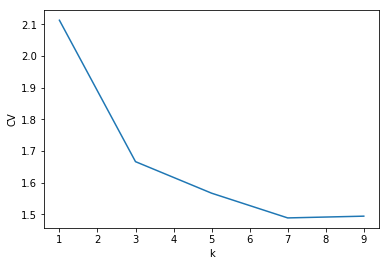

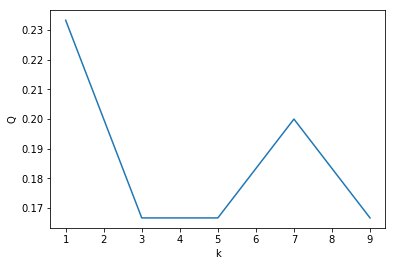

best k: 7
Q(testx, testy) 7 : 0.2
F1(testx, testy) 7 : 0.823529411764706


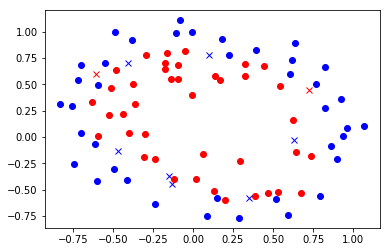

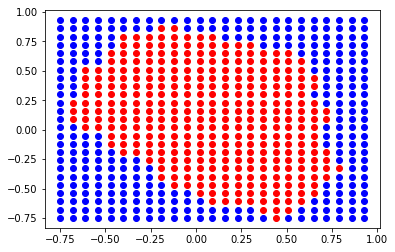

In [16]:
#добавляем третюю компоненту(x ** 2 + y  ** 2), L2
show_info(getMinkowskiDistance(2), trans1, defQ, CVks = range(5,11))

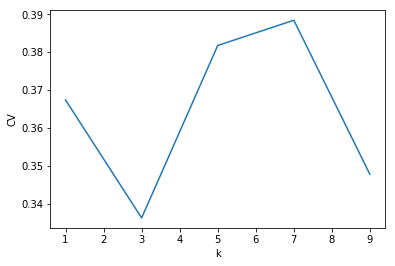

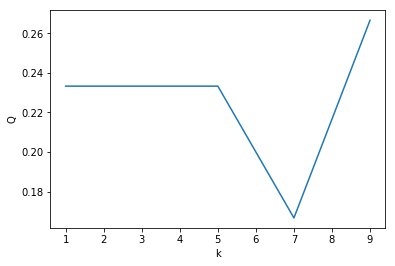

best k: 3
Q(testx, testy) 3 : 0.23333333333333334
F1(testx, testy) 3 : 0.7999999999999999


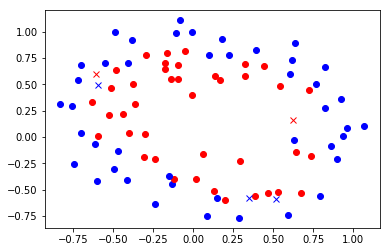

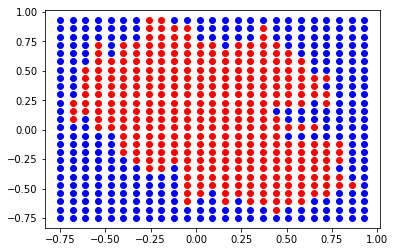

In [17]:
#добавляем третюю компоненту(x * y), L1
show_info(getMinkowskiDistance(1), trans2, defQ)

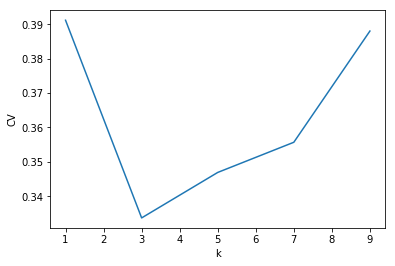

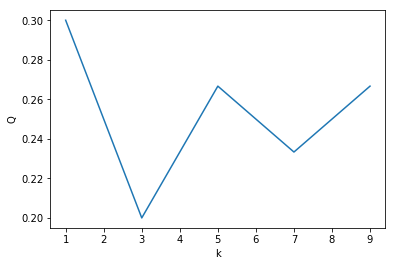

best k: 3
Q(testx, testy) 3 : 0.2
F1(testx, testy) 3 : 0.823529411764706


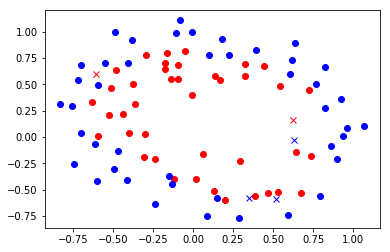

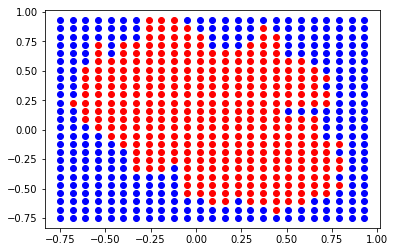

In [18]:
#добавляем третюю компоненту(x * y), L2
show_info(getMinkowskiDistance(2), trans2, defQ)

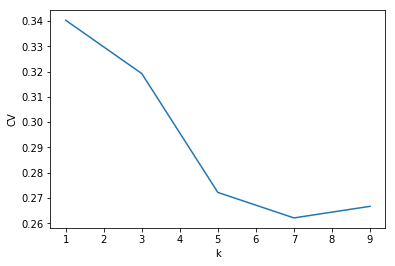

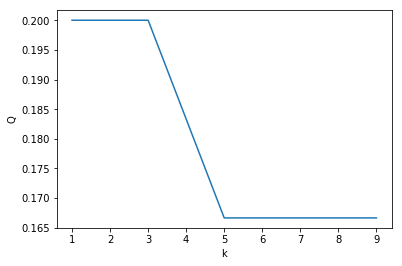

best k: 7
Q(testx, testy) 7 : 0.16666666666666666
F1(testx, testy) 7 : 0.8484848484848485


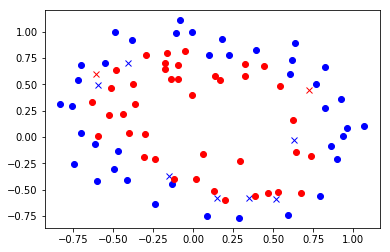

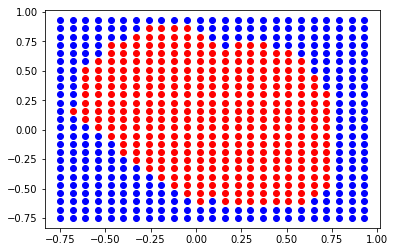

In [19]:
#добавляем третюю компоненту(x ** 2 + y ** 2), L1
show_info(getMinkowskiDistance(1), trans1, defQ, kernel_f=cosine)

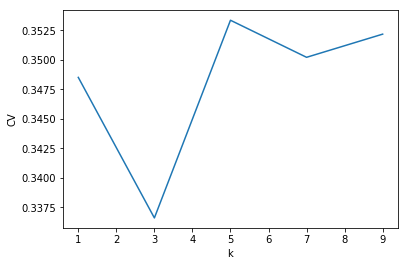

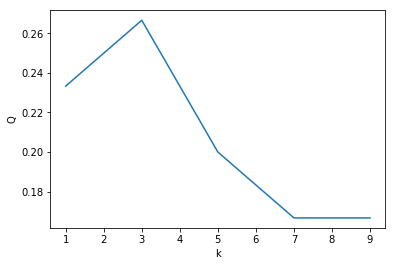

best k: 3
Q(testx, testy) 3 : 0.26666666666666666
F1(testx, testy) 3 : 0.75


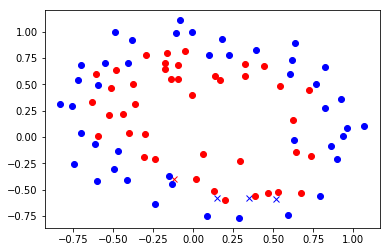

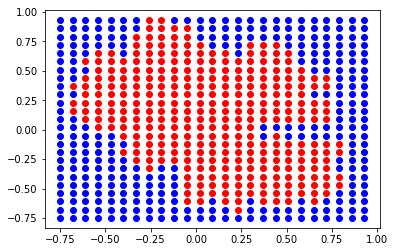

In [20]:
#добавляем третюю компоненту(x * y), L1
show_info(getMinkowskiDistance(1), trans2, defQ, kernel_f=cosine)

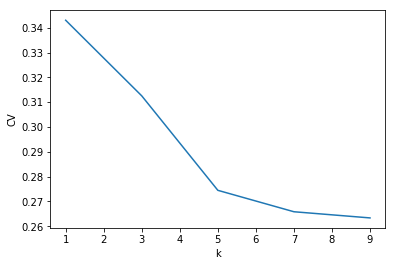

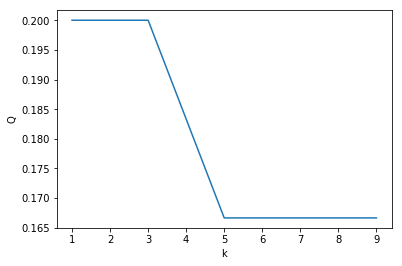

best k: 9
Q(testx, testy) 9 : 0.16666666666666666
F1(testx, testy) 9 : 0.8484848484848485


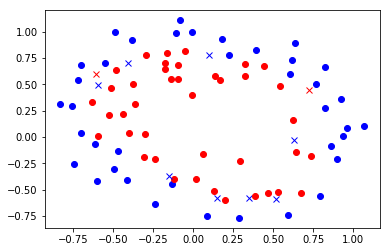

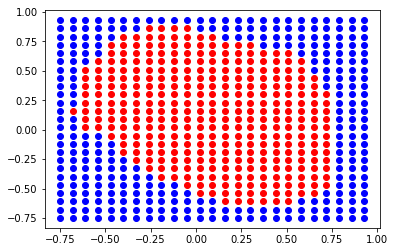

In [21]:
#добавляем третюю компоненту(x * y), L2
show_info(getMinkowskiDistance(1), trans1, defQ, kernel_f=epanechnikov)

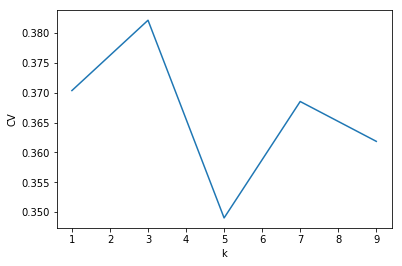

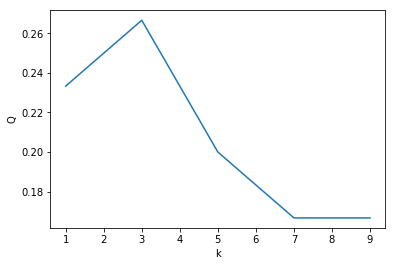

best k: 5
Q(testx, testy) 5 : 0.2
F1(testx, testy) 5 : 0.823529411764706


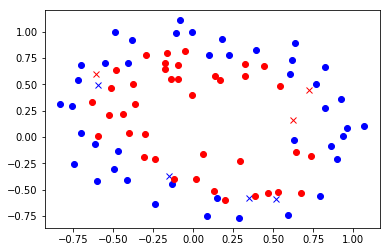

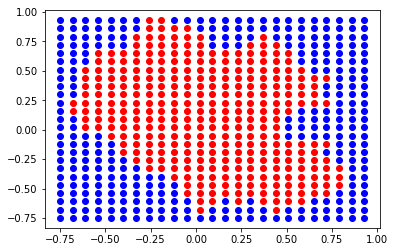

In [22]:
#добавляем третюю компоненту(x * y), L2
show_info(getMinkowskiDistance(1), trans2, defQ, kernel_f=epanechnikov)